# Part 1: Data Cleaning for Trip Fare Prediction

This notebook walks through the process of cleaning the raw trip data from the provided SQLite database (`.db` file). The goal is to identify and resolve issues such as missing data, incorrect data types, and invalid values to prepare a clean dataset for analysis and machine learning.

### Step 1: Load and Initial Inspection

In [31]:
import pandas as pd
import sqlite3
import numpy as np

# visualisations
import seaborn as sns
import matplotlib.pyplot as plt

In [32]:
db_file = '../data/SpaceTravelAgency.db'

conn = sqlite3.connect(db_file)

cursor = conn.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()
print(f"Tables in the database: {tables}")

# load all tables into a dictionary
dfs = {}
for table_name_tuple in tables:
    table_name = table_name_tuple[0]
    df = pd.read_sql_query(f"SELECT * FROM {table_name}", conn)
    dfs[table_name] = df


transport = dfs['Transport']
trip = dfs['Trip']
celestial_object = dfs['CelestialObject']
visit = dfs['Visit']
customer = dfs['Customer']
participant = dfs['Participant']


conn.close()


Tables in the database: [('Transport',), ('Trip',), ('CelestialObject',), ('Visit',), ('Customer',), ('Participant',)]


In [33]:
transport

,code,description
0,RV,space shuttle
1,BU,beam up
2,FTL,faster than light cruiser


Now that the data is loaded into a pandas DataFrame, let's write a function that we can run on every df to see what we need to clean

In [34]:
def inspect_dataframe(df, df_name="DataFrame", visualize=True):
    """
    performs a general inspection of a pandas dataframe, prints a summary
    of potential data quality issues, and creates visualizations.

    args:
        df (pd.dataframe): the dataframe to inspect.
        df_name (str): the name of the dataframe for display purposes.
        visualize (bool): if true, generates and displays plots.
    """
    print(f"--- inspecting {df_name} ---")
    print(f"shape: {df.shape[0]} rows, {df.shape[1]} columns")

    # 1. missing value analysis (text report)
    print("\n--- 1. missing values ---")
    missing_values = df.isnull().sum()
    missing_percent = (missing_values / df.shape[0]) * 100
    missing_df = pd.DataFrame({
        'missing_count': missing_values,
        'missing_percent': missing_percent
    })
    missing_df = missing_df[missing_df['missing_count'] > 0].sort_values(by='missing_percent', ascending=False)

    if not missing_df.empty:
        print("columns with missing values:")
        print(missing_df.round(2))
    else:
        print("no missing values found.")

    # 2. data type and uniqueness (text report)
    print("\n--- 2. data types & unique values ---")
    dtype_df = df.dtypes.to_frame('dtype')
    dtype_df['unique_values'] = df.nunique()
    print(dtype_df)
    
    # 3. numerical data sanity check (text report)
    print("\n--- 3. numerical data sanity check ---")
    numeric_cols = df.select_dtypes(include=np.number).columns
    if len(numeric_cols) == 0:
        print("no numerical columns to check.")
    else:
        for col in numeric_cols:
            if (df[col] <= 0).any():
                print(f"- '{col}' contains zero or negative values. investigate if this is valid.")
            mean = df[col].mean()
            std = df[col].std()
            outliers = df[(np.abs(df[col] - mean)) > (3 * std)]
            if not outliers.empty:
                print(f"- '{col}' has {len(outliers)} potential outliers (>3 std from mean).")
    
    print("\n--- inspection report complete ---")

    if not visualize:
        return

    # --- 4. visual analysis ---
    print("\n--- visual analysis ---")
    sns.set_style("whitegrid")

    # plotting distributions for numerical columns
    if len(numeric_cols) > 0:
        print(f"\nplotting distributions for {len(numeric_cols)} numerical columns...")
        num_plots = len(numeric_cols)
        num_cols = 3
        num_rows = (num_plots - 1) // num_cols + 1
        
        fig1, axes1 = plt.subplots(num_rows, num_cols, figsize=(15, 4 * num_rows))
        axes1 = axes1.flatten()
        for i, col in enumerate(numeric_cols):
            sns.histplot(df[col], kde=True, ax=axes1[i], bins=30)
            axes1[i].set_title(f"distribution of {col}", fontsize=12)
        # hide empty subplots
        for j in range(i + 1, len(axes1)):
            axes1[j].set_visible(False)
        plt.tight_layout()
        plt.show()

        # box plots for numerical columns to spot outliers
        fig2, axes2 = plt.subplots(num_rows, num_cols, figsize=(15, 4 * num_rows))
        axes2 = axes2.flatten()
        for i, col in enumerate(numeric_cols):
            sns.boxplot(x=df[col], ax=axes2[i])
            axes2[i].set_title(f"box plot of {col}", fontsize=12)
        # hide empty subplots
        for j in range(i + 1, len(axes2)):
            axes2[j].set_visible(False)
        plt.tight_layout()
        plt.show()

    else:
        print("\nno numerical columns to visualize.")

    # plotting counts for categorical columns
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns
    # filter for categorical columns with a manageable number of unique values
    plottable_cats = [col for col in categorical_cols if df[col].nunique() < 25]

    if len(plottable_cats) > 0:
        print(f"\nplotting value counts for {len(plottable_cats)} categorical columns...")
        num_plots = len(plottable_cats)
        num_cols = 2
        num_rows = (num_plots - 1) // num_cols + 1

        fig3, axes3 = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
        axes3 = axes3.flatten()
        for i, col in enumerate(plottable_cats):
            sns.countplot(y=df[col], ax=axes3[i], order=df[col].value_counts().index)
            axes3[i].set_title(f"value counts for {col}", fontsize=12)
            axes3[i].set_xlabel("count")
            axes3[i].set_ylabel("") # the category names are on the y-axis
        # hide empty subplots
        for j in range(i + 1, len(axes3)):
            axes3[j].set_visible(False)
        plt.tight_layout()
        plt.show()
    else:
        print("\nno plottable categorical columns found.")

--- inspecting DataFrame ---
shape: 3 rows, 2 columns

--- 1. missing values ---
no missing values found.

--- 2. data types & unique values ---
              dtype  unique_values
code         object              3
description  object              3

--- 3. numerical data sanity check ---
no numerical columns to check.

--- inspection report complete ---

--- visual analysis ---

no numerical columns to visualize.

plotting value counts for 2 categorical columns...


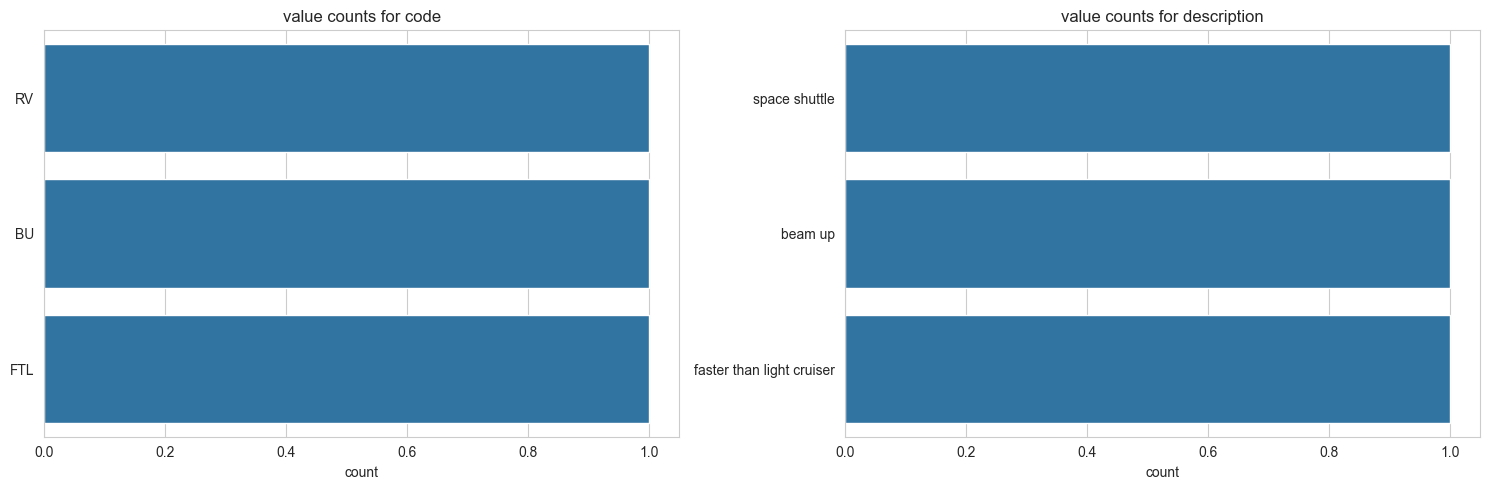

In [35]:
inspect_dataframe(transport)

--- inspecting DataFrame ---
shape: 200 rows, 5 columns

--- 1. missing values ---
columns with missing values:
          missing_count  missing_percent
duration             13              6.5
price                13              6.5

--- 2. data types & unique values ---
                  dtype  unique_values
number            int64            200
departure_date   object            191
transport        object              3
duration        float64            148
price           float64            187

--- 3. numerical data sanity check ---

--- inspection report complete ---

--- visual analysis ---

plotting distributions for 3 numerical columns...


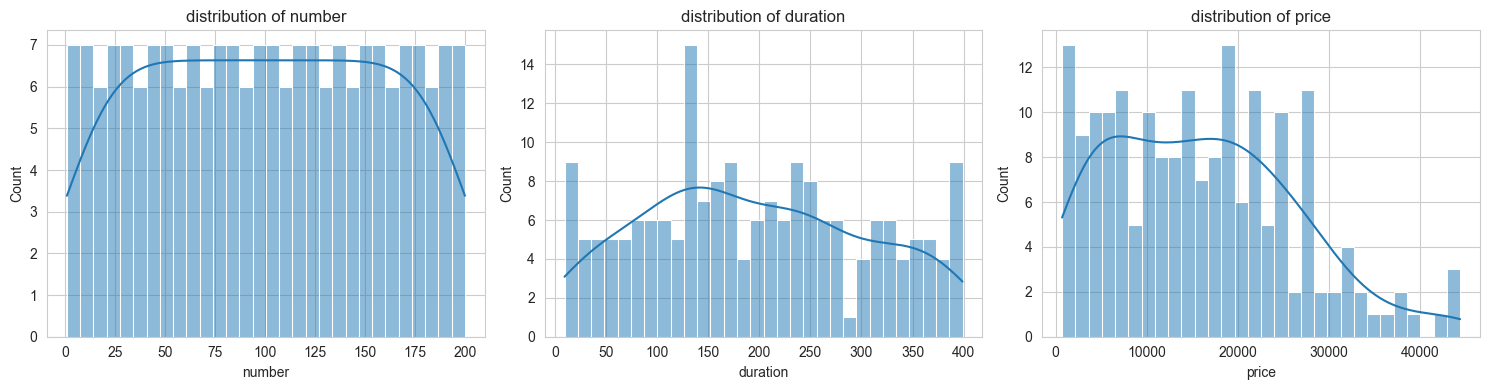

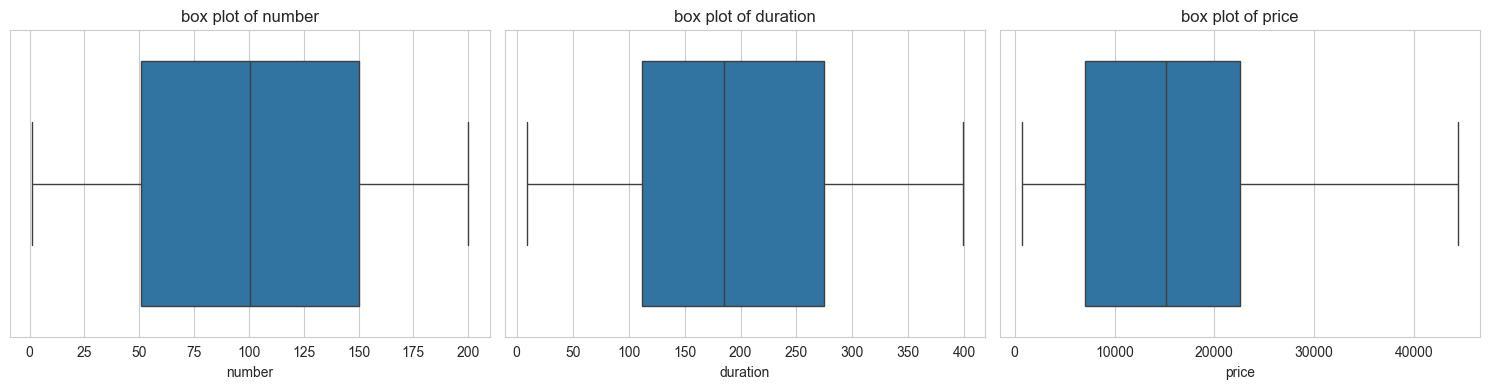


plotting value counts for 1 categorical columns...


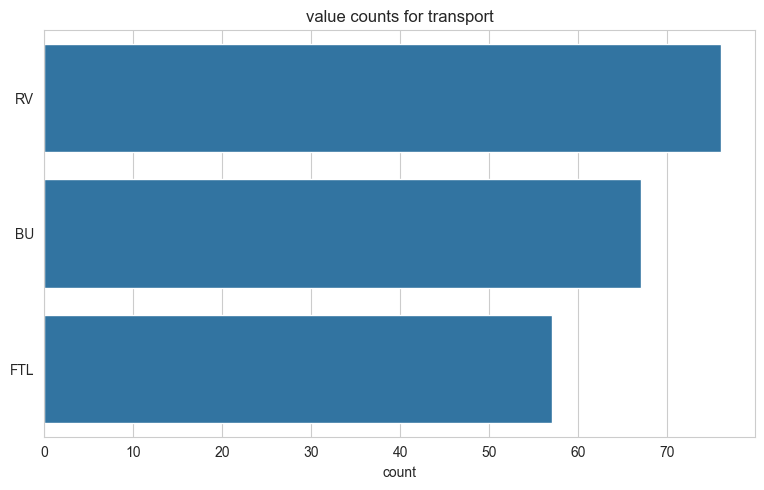

In [36]:
inspect_dataframe(trip)

--- inspecting DataFrame ---
shape: 13 rows, 4 columns

--- 1. missing values ---
columns with missing values:
                             missing_count  missing_percent
parent_object                            1             7.69
distance_from_parent_1000km              1             7.69

--- 2. data types & unique values ---
                               dtype  unique_values
name                          object             13
parent_object                 object              5
distance_from_parent_1000km  float64             12
diameter_km                    int64             13

--- 3. numerical data sanity check ---
- 'diameter_km' has 1 potential outliers (>3 std from mean).

--- inspection report complete ---

--- visual analysis ---

plotting distributions for 2 numerical columns...


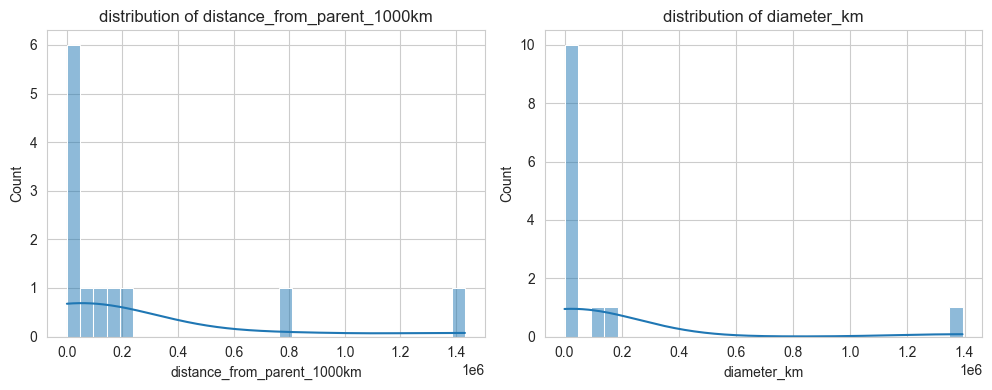

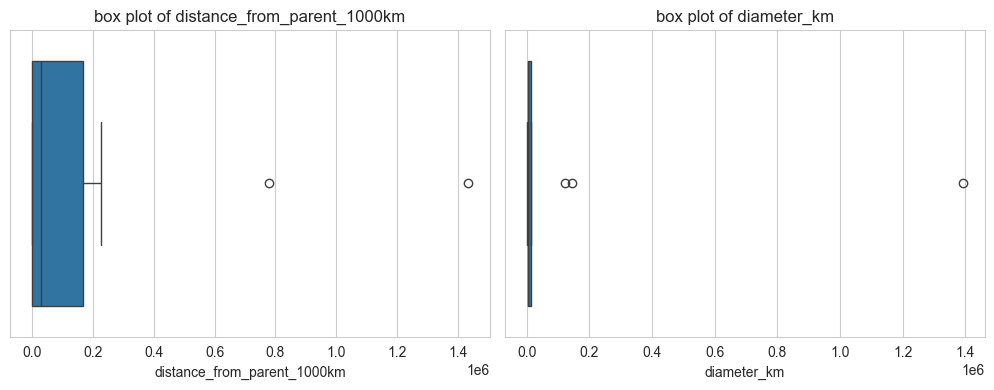


plotting value counts for 2 categorical columns...


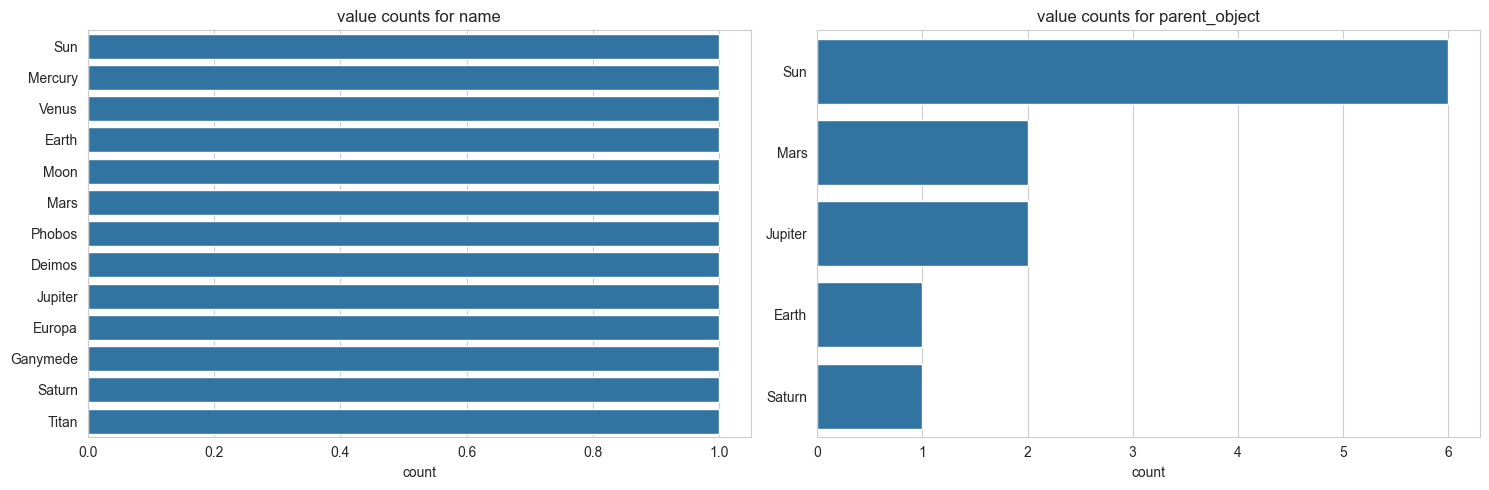

In [37]:
inspect_dataframe(celestial_object)

--- inspecting DataFrame ---
shape: 568 rows, 4 columns

--- 1. missing values ---
no missing values found.

--- 2. data types & unique values ---
                   dtype  unique_values
trip               int64            187
sequence_number    int64              5
celestial_object  object             12
stay_duration      int64            186

--- 3. numerical data sanity check ---
- 'stay_duration' contains zero or negative values. investigate if this is valid.
- 'stay_duration' has 2 potential outliers (>3 std from mean).

--- inspection report complete ---

--- visual analysis ---

plotting distributions for 3 numerical columns...


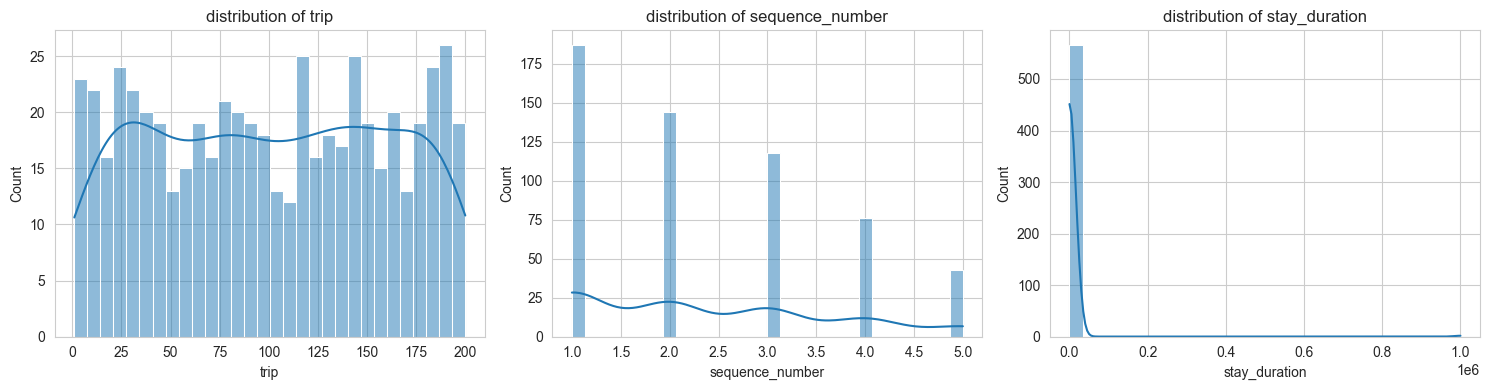

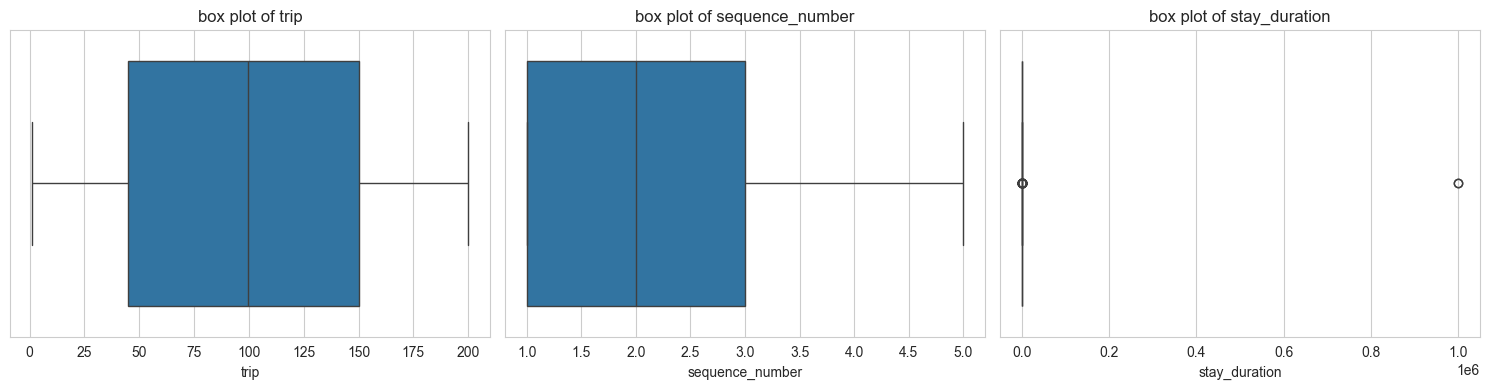


plotting value counts for 1 categorical columns...


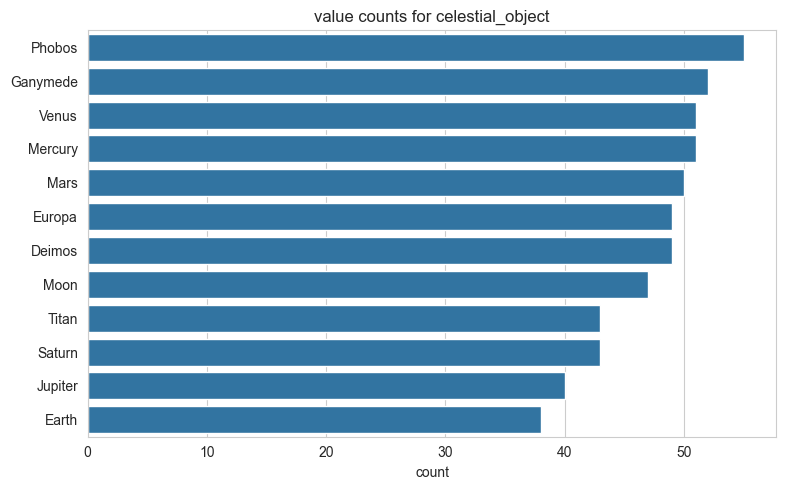

In [38]:
inspect_dataframe(visit)

--- inspecting DataFrame ---
shape: 500 rows, 3 columns

--- 1. missing values ---
no missing values found.

--- 2. data types & unique values ---
             dtype  unique_values
number       int64            500
name        object            500
birth_date  object            496

--- 3. numerical data sanity check ---

--- inspection report complete ---

--- visual analysis ---

plotting distributions for 1 numerical columns...


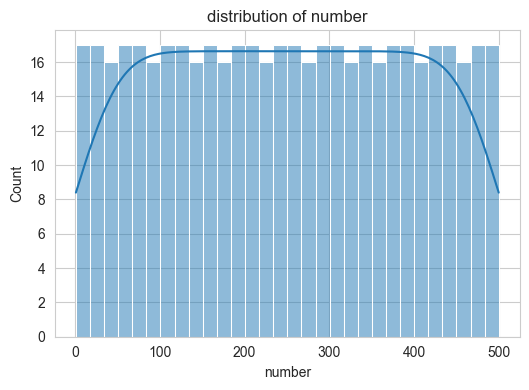

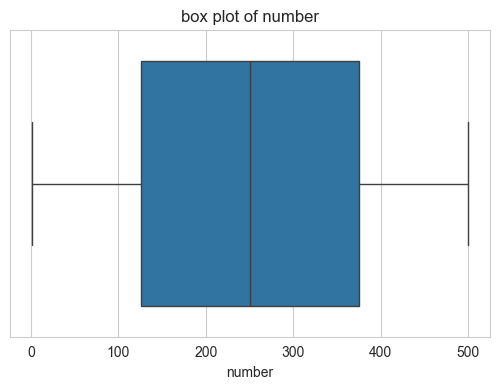


no plottable categorical columns found.


In [39]:
inspect_dataframe(customer)

--- inspecting DataFrame ---
shape: 1585 rows, 2 columns

--- 1. missing values ---
no missing values found.

--- 2. data types & unique values ---
          dtype  unique_values
trip      int64            200
customer  int64            486

--- 3. numerical data sanity check ---

--- inspection report complete ---

--- visual analysis ---

plotting distributions for 2 numerical columns...


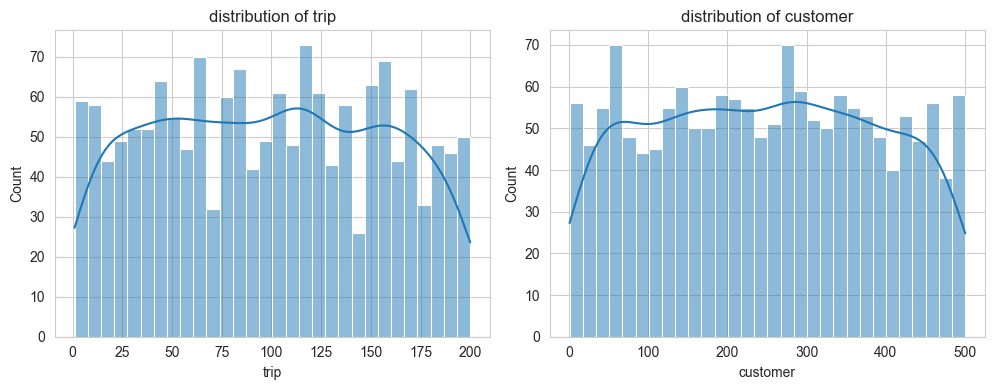

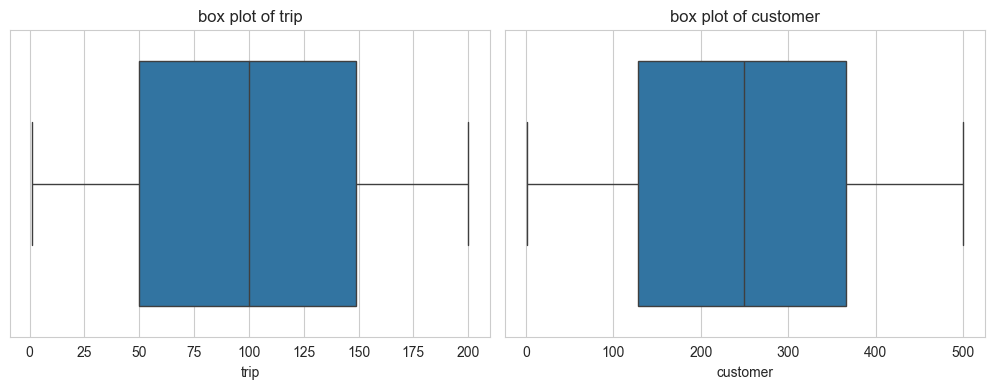


no plottable categorical columns found.


In [40]:
inspect_dataframe(participant)

 ---
# Data Cleaning Plan & Justification
### Here is a summary of the data quality issues found in each table and the recommended cleaning actions.

 --- 
### Trip Table
This is the most critical table as it contains our target variable (price) and key features.

#### Problem 1: Missing price and duration data.

The inspection revealed that 6.5% of the rows are missing both price and duration.

Action: Since price is the target variable for the machine learning model, we cannot impute its value. The only reliable option is to drop these 13 rows. This will ensure the model is trained only on complete and valid records.


#### Problem 2: Incorrect departure_date data type.

The departure_date column is currently stored as an object (text).

Action: Convert this column to a datetime object using pd.to_datetime(). This is essential for any time-based analysis or feature engineering (e.g., extracting the month or year of the trip).

 --- 
### CelestialObject Table
This table describes the destinations.


#### Problem 1: Missing parent_object and distance_from_parent_1000km.

There is one record missing these values. This is likely the central object of the system (e.g., the Sun), which has no parent.

Action: This is not an error, but a feature of hierarchical data. Fill the missing parent_object with a placeholder like 'None'. Fill the missing distance_from_parent_1000km with 0.


#### Problem 2: Outlier in diameter_km.

One object has a diameter that is statistically an outlier.

Action: Investigate, but do not remove. This is almost certainly a valid data point representing a star or a gas giant, which is naturally much larger than other objects like moons or planets. Removing it would be deleting correct information. For modeling, a log transformation (np.log1p) can help normalize this distribution.

 ---

### Visit Table
This table details the stops on each trip.

#### Problem 1: Invalid stay_duration values.

The inspection found that stay_duration contains zero or negative values.

Action: A negative stay duration is impossible. Filter out and remove any rows where stay_duration is less than 0. Investigate the rows where duration is exactly 0; these might be valid "fly-by" events, but if they are errors, they should also be removed.

 ---

### Customer Table
This table contains customer information.

#### Problem 1: Incorrect birth_date data type.

The birth_date column is stored as an object (text).

Action: Convert this column to a datetime object using pd.to_datetime(). This allows for calculations like customer age.

 ---
### Clean Tables
The following tables appear to be clean and require no action:

Transport

Participant